In [1]:
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df_sneakers = pd.read_csv(r'sneakers.csv')

In [3]:
df_sneakers['created_at'] = pd.to_datetime(df_sneakers['created_at'])
df_sneakers.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


In [4]:
df_sneakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        5000 non-null   int64         
 1   shop_id         5000 non-null   int64         
 2   user_id         5000 non-null   int64         
 3   order_amount    5000 non-null   int64         
 4   total_items     5000 non-null   int64         
 5   payment_method  5000 non-null   object        
 6   created_at      5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 273.6+ KB


In [5]:
df_sneakers.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


The above table gives useful information about total items. The max number of total items bought in one purchase is 2000. Given that 75% values have less than equal to 3 total items per order, 2000 seems like an outlier value that, where someone has placed a large order in bulk for the sneakers.

This may be a cause as to why there is discrepancy with the Average Order Value. The standard deviation value for the order amount is also extremely far from the mean, which means that the data is quite spread out and mean might not be the right metric to assess this data. 

It is best to explore into the data to further understand if there's anomalies in the dataset causing a high AOV.

In [6]:
grouped_orders = df_sneakers.groupby('total_items').agg({'order_id': 'count'})
grouped_orders.reset_index(drop=False, inplace=True)
grouped_orders

,total_items,order_id
0,1,1830
1,2,1832
2,3,941
3,4,293
4,5,77
5,6,9
6,8,1
7,2000,17


### Plotting the frequency of occurence of Total Items

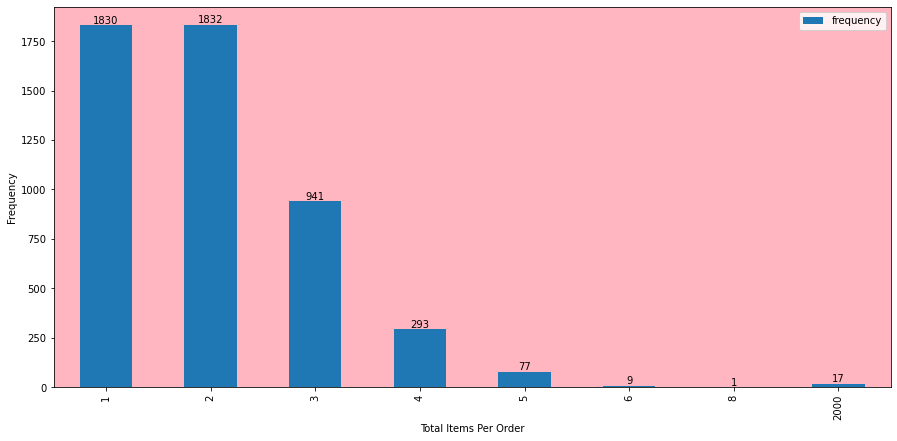

In [7]:
fig, ax = plt.subplots()
freq = pd.DataFrame(df_sneakers['total_items'].value_counts()).reset_index(drop=False).rename({'index': 'total_items', 'total_items': 'frequency'}, axis=1)
freq.sort_values(by=['total_items'], inplace=True)
freq.plot.bar(x = 'total_items', y = 'frequency', xlabel= 'Total Items Per Order', ylabel = 'Frequency', figsize=(15, 7), ax=ax)
ax.set_facecolor('lightpink')
ax.bar_label(ax.containers[0]);

### Number of Purchases per store

In [8]:
grouped_df = df_sneakers.groupby('shop_id').agg({'order_id': 'count'}).reset_index(drop=False)
grouped_df.head()

,shop_id,order_id
0,1,44
1,2,55
2,3,48
3,4,51
4,5,45


Text(0, 0.5, 'Number of Purchases')

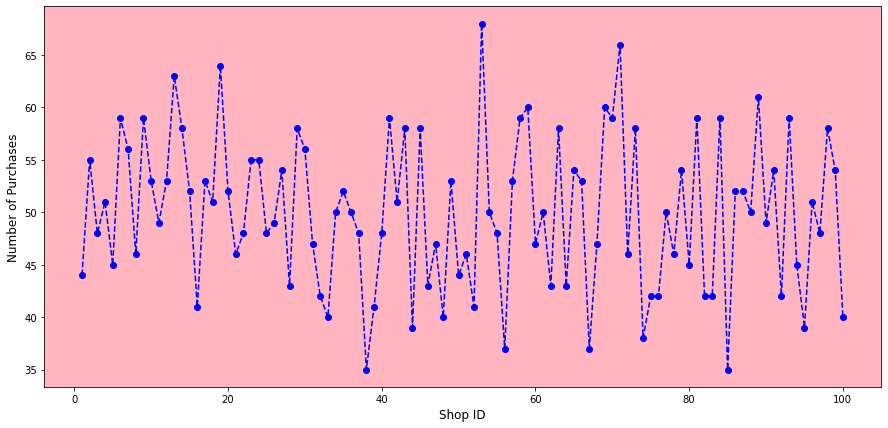

In [9]:
fig, ax0 = plt.subplots()
fig.set_size_inches(15, 7)
ax0.plot(grouped_df.shop_id, grouped_df.order_id, color='blue', marker = 'o', linestyle='dashed')
ax0.set_facecolor('lightpink')
plt.xlabel('Shop ID', fontsize = 12)
plt.ylabel('Number of Purchases', fontsize=12)

### Segregate all the data by shops

In [10]:
store_df = dict()

unique_stores = df_sneakers.shop_id.sort_values().unique()
unique_stores

for store_id in unique_stores:
    store_df[store_id] = df_sneakers.loc[df_sneakers['shop_id'] == store_id]
    

In [11]:
first_shop = store_df[1].copy()

In [12]:
first_shop.sort_values('created_at', inplace=True)
first_shop['created_at'] = pd.to_datetime(first_shop['created_at'])
first_shop['created_at_date'] = first_shop['created_at'].dt.date
grouped_time_fs = first_shop.groupby('created_at_date').agg({'order_id':'count'})

In [13]:
grouped_time_fs.reset_index(drop=False, inplace=True)

## Q1a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

### Answer:

## Average Order Value

### Formula = Revenue/Number of Orders

In [14]:
#$3145.13
original = df_sneakers.order_amount.sum()/df_sneakers.order_id.count()
original

3145.128


This Average Order Value is $3145 because of outliers in the total items column for some of the orders. There's 17 occurences of orders where 2000 sneakers have been billed for. This is skewing the Average Order Value. 

In order to understand this value further, it's best to segregate the average order value for each store. 



In [15]:
shop_orders = pd.DataFrame(round(df_sneakers.groupby('shop_id')['order_amount'].mean(),2)).reset_index(drop=False)
shop_orders.sort_values('order_amount', ascending=False, inplace=True)
shop_orders_wo = shop_orders.iloc[2:, ]

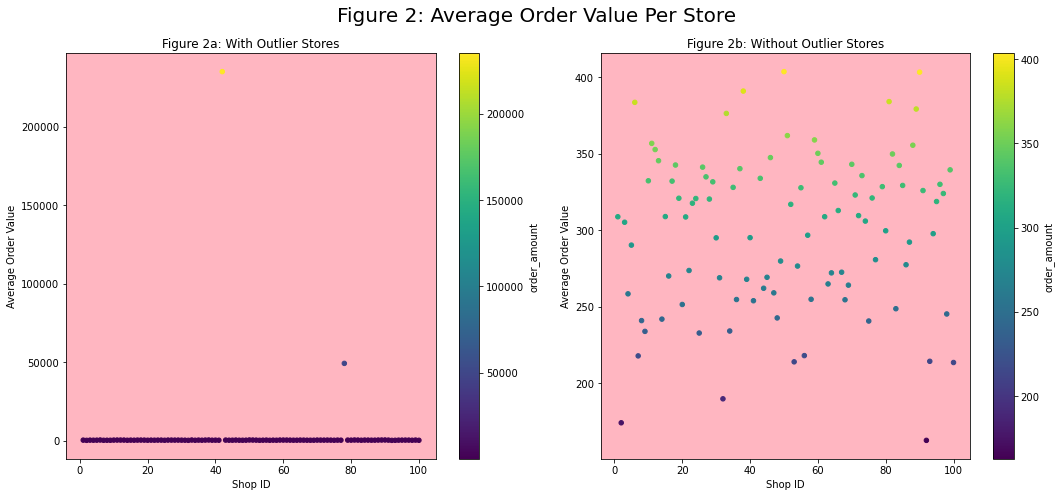

In [16]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Figure 2: Average Order Value Per Store', fontsize=20)

ax1.set_title('Figure 2a: With Outlier Stores')
ax1.set_facecolor('lightpink')
shop_orders.plot.scatter('shop_id','order_amount', figsize=(15, 7), c= 'order_amount', colormap= 'viridis', ax= ax1)
ax1.set_xlabel('Shop ID')
ax1.set_ylabel('Average Order Value')


ax2.set_title('Figure 2b: Without Outlier Stores')
ax2.set_facecolor('lightpink')
shop_orders_wo.plot.scatter('shop_id','order_amount', figsize=(15, 7), c= 'order_amount', colormap= 'viridis', ax= ax2)
ax2.set_xlabel('Shop ID')
ax2.set_ylabel('Average Order Value')

plt.tight_layout()


It is visible from the above plot that there are 2 shops, which have a significantly higher average order value than all the other shops.

In [17]:
shop_orders.sort_values(by='order_amount', ascending=False, inplace=True)

shop_orders.head(2)\
           .rename({'shop_id': 'Shop ID', 'order_amount': 'Average Order Value'}, axis=1)\
           .reset_index(drop=True)

,Shop ID,Average Order Value
0,42,235101.49
1,78,49213.04


Shops 42 has the highest average order value with USD 235101.49 while shop 78 has the second highest with
USD 49213.04.

If the two shops are removed from the cumulative AOV calculation, the results are not biased towards the extreme outliers anymore.

### Shop 42

In [18]:
shop42 = df_sneakers[df_sneakers.shop_id == 42]
shop42['created_at_date'] = shop42.created_at.dt.date
shop42['created_at_time'] = shop42.created_at.dt.time

/var/folders/rl/t9fx_p3x0lgbtnvhyj_gjcwh0000gn/T/ipykernel_46895/719502936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop42['created_at_date'] = shop42.created_at.dt.date
/var/folders/rl/t9fx_p3x0lgbtnvhyj_gjcwh0000gn/T/ipykernel_46895/719502936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop42['created_at_time'] = shop42.created_at.dt.time


In [19]:
shop42 = shop42.sort_values(by=['order_amount', 'created_at_date'], ascending=False).reset_index(drop=True)
shop42.tail()


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,created_at_date,created_at_time
46,309,42,770,352,1,credit_card,2017-03-11 18:14:39,2017-03-11,18:14:39
47,4626,42,809,352,1,credit_card,2017-03-11 08:21:26,2017-03-11,08:21:26
48,3999,42,886,352,1,debit,2017-03-09 20:10:41,2017-03-09,20:10:41
49,4232,42,962,352,1,cash,2017-03-04 00:01:19,2017-03-04,00:01:19
50,2019,42,739,352,1,debit,2017-03-01 12:42:26,2017-03-01,12:42:26


In [20]:
user_activity = shop42.groupby('user_id').agg({'order_id': 'count', 'total_items': 'sum', 'created_at':'nunique', 'created_at_time':'nunique', 'order_amount':'sum'}).reset_index(drop=False)
user_activity.rename({'order_id': 'Number of Orders', 'created_at':'Number of Unique Dates', 'created_at_time':'Number of Unique Timestamps', 'order_amount': 'Total Payment Made'}, axis=1, inplace=True)


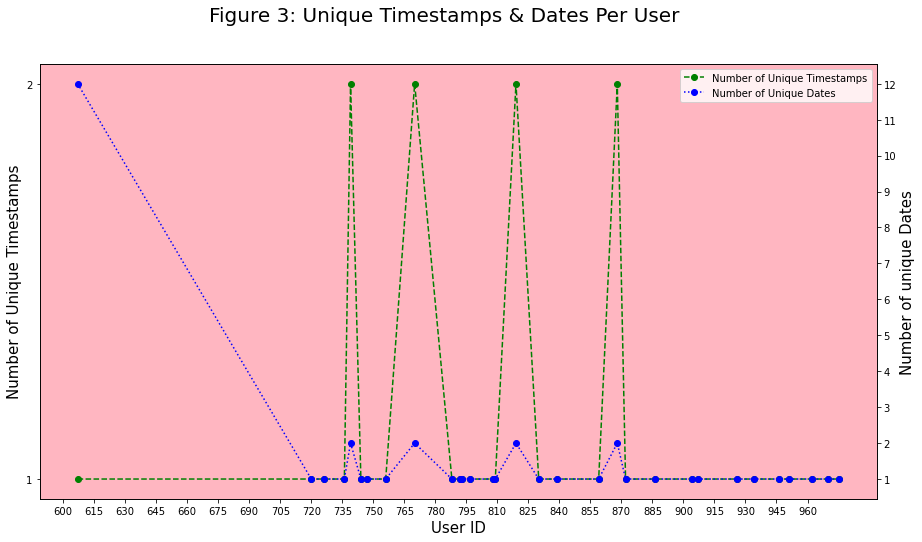

In [21]:
fig, ax3 = plt.subplots()
fig.suptitle('Figure 3: Unique Timestamps & Dates Per User', fontsize=20)
ax4 = ax3.twinx()
fig.set_size_inches(15, 8)

ln1 = ax3.plot(user_activity['user_id'], user_activity['Number of Unique Timestamps'], label='Number of Unique Timestamps', marker = 'o', linestyle='dashed', color = 'green')
ax3.set_xlabel('User ID', fontsize=15)
ax3.set_ylabel('Number of Unique Timestamps', fontsize=15)
ax3.set_xticks(np.arange(600, max(user_activity['user_id']), 15))
ax3.set_yticks(np.arange(1, max(user_activity['Number of Unique Timestamps'])+1, 1))
ax3.set_facecolor('lightpink')

ln2 = ax4.plot(user_activity['user_id'], user_activity['Number of Unique Dates'], label = 'Number of Unique Dates', marker = 'o', linestyle ='dotted', color = 'blue')
ax4.set_ylabel('Number of unique Dates', fontsize=15)
ax4.set_yticks(np.arange(1, max(user_activity['Number of Unique Dates'])+1, 1))

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax4.legend(lns, labs, loc=0);



The figure above is a plot representing the number of unique timestamps and the number of unique dates on which each customer of Shop 42 placed an order on. The dots on lines represent the customers/users.

All but one customer who've had multiple orders have placed on different timestamps. 

It can be seen that one customer, right at the beginning of the plot(left side) has placed 12 orders but at the same time on 12 different dates.

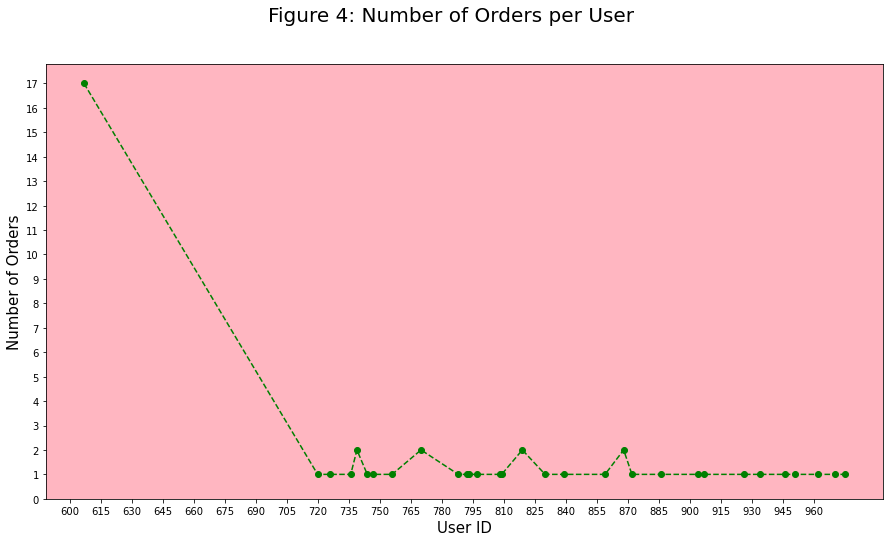

In [22]:
fig, ax5 = plt.subplots()
fig.suptitle('Figure 4: Number of Orders per User', fontsize=20)

fig.set_size_inches(15, 8)

ln1 = ax5.plot(user_activity['user_id'], user_activity['Number of Orders'], label='Number of Orders', marker = 'o', linestyle='dashed', color = 'green')
ax5.set_xticks(np.arange(600, max(user_activity['user_id']), 15))
ax5.set_yticks(np.arange(0, max(user_activity['Number of Orders'])+1, 1))
ax5.set_xlabel('User ID', fontsize=15)
ax5.set_ylabel('Number of Orders', fontsize=15)
ax5.set_facecolor('lightpink')


Figure 4 states that all but one customer make at most 2 orders from Shop 42. It seems probable that the anomaly regarding the customer in Figure 3 and the 17 orders made by one customer as seen from Figure 4 are related to the same customer as there is only one dotted point on the graph for users having ID less than 700. All the other users have ID greater than 700. 

In [23]:
user_activity.loc[user_activity.user_id < 700]

,user_id,Number of Orders,total_items,Number of Unique Dates,Number of Unique Timestamps,Total Payment Made
0,607,17,34000,12,1,11968000


By checking for the user whose ID is under 700, it can be seen that this user has made 17 orders, out of which 12 have been made on different dates, however there's 5 orders made at redundant dates. All the orders are made at the same hour of the day. It is worth looking at this user's purchase history.


In [24]:
shop42.loc[shop42['user_id'] == 607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,created_at_date,created_at_time
0,2836,42,607,704000,2000,credit_card,2017-03-28 04:00:00,2017-03-28,04:00:00
1,2970,42,607,704000,2000,credit_card,2017-03-28 04:00:00,2017-03-28,04:00:00
2,4057,42,607,704000,2000,credit_card,2017-03-28 04:00:00,2017-03-28,04:00:00
3,4883,42,607,704000,2000,credit_card,2017-03-25 04:00:00,2017-03-25,04:00:00
4,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00,2017-03-24,04:00:00
5,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00,2017-03-24,04:00:00
6,4869,42,607,704000,2000,credit_card,2017-03-22 04:00:00,2017-03-22,04:00:00
7,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00,2017-03-19,04:00:00
8,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,2017-03-17,04:00:00
9,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00,2017-03-15,04:00:00


As user 607 has made certain purchases, it can be seen that the same number of sneakers are being purchased by the same user across multiple dates and on the same dates as well. In fact, the purchases made by this user on one day have been at one single instance of time. The purchases made on other days have also been at 4:00:00. 

The orders being made on the same day have different Order IDs, which could mean that this might be a fraudulent transaction. All the payments have been made via credit card for the same quantity in each order, which strenghtens the suspicion. As the timestamp is also 4:00:00, there's possibility of a malicious program being executed that's placing these orders.

The presence of this activity is also part of the reason as to why the Average Order Value is Biased.


### Shop 78

In [25]:
shop78 = df_sneakers[df_sneakers.shop_id == 78]

In [26]:
shop78.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
160,161,78,990,25725,1,credit_card,2017-03-12 05:56:57
490,491,78,936,51450,2,debit,2017-03-26 17:08:19
493,494,78,983,51450,2,cash,2017-03-16 21:39:35
511,512,78,967,51450,2,cash,2017-03-09 07:23:14
617,618,78,760,51450,2,cash,2017-03-18 11:18:42


Just by looking at the first 5 values of the data for shop 78, it's evident that the order amount is extremely high as compared to the number of items which are at most 2. 

In [27]:
shop78.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,46.000000,46.0,46.000000,46.000000,46.000000
mean,2663.021739,78.0,867.739130,49213.043478,1.913043
std,1338.520020,0.0,81.314871,26472.227449,1.029047
min,161.000000,78.0,707.000000,25725.000000,1.000000
25%,1428.250000,78.0,812.500000,25725.000000,1.000000
50%,2796.500000,78.0,866.500000,51450.000000,2.000000
75%,3720.250000,78.0,935.750000,51450.000000,2.000000
max,4919.000000,78.0,997.000000,154350.000000,6.000000


After viewing the table above, it can be seen that the total items per order are anywhere between 1 and 6. Although, the mean is 1.9 with standard deviation approximately 1, which implies that most customers have the total number of items in their orders close to the mean. So that could be between 1 and 3 (inclusive). By looking at the 3rd quartile, it's evident that 75% of the total items per order placed are less than or equal to 2. 

Unfortunately, similar views could not be stated for the order amount. The standard deviation of USD 26472.22 is extremely high, which implies that most amounts for orders in dataset are far away from the average price for an order in Shop 78. Mean might not be a good estimate for the Average Order Value in this case. 


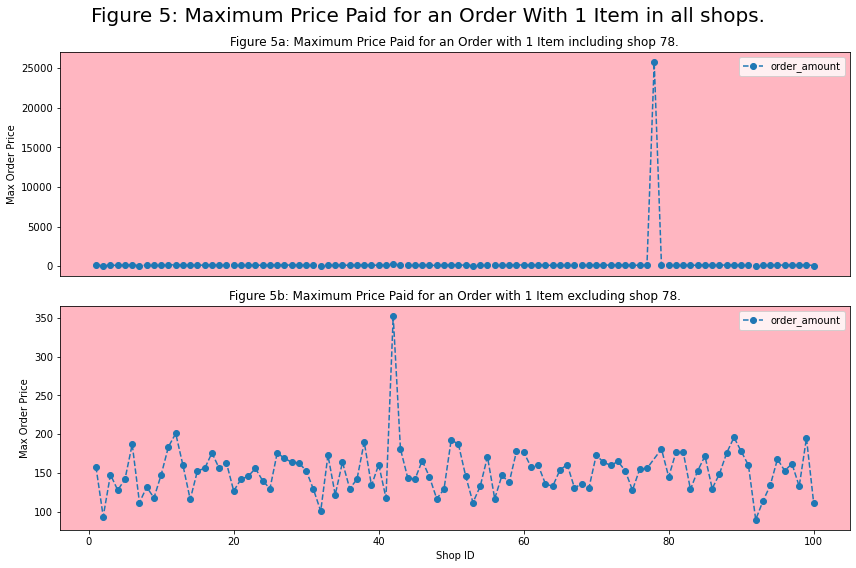

In [28]:
single_item_users = df_sneakers.loc[df_sneakers.total_items == 1]
single_item_users_bar78 = single_item_users.loc[single_item_users['shop_id'] != 78]

fig, (ax6, ax7) = plt.subplots(2)
fig.suptitle('Figure 5: Maximum Price Paid for an Order With 1 Item in all shops.', fontsize=20)

ax6.set_title('Figure 5a: Maximum Price Paid for an Order with 1 Item including shop 78.')
single_item_users.groupby('shop_id').agg({'order_amount': 'max'}).sort_values(by= 'shop_id').plot(ylabel = 'Max Order Price', marker= 'o', linestyle= 'dashed', figsize=(12,8), ax= ax6)
ax6.axes.xaxis.set_visible(False)
ax6.set_facecolor('lightpink')

ax7.set_title('Figure 5b: Maximum Price Paid for an Order with 1 Item excluding shop 78.')
single_item_users_bar78.groupby('shop_id').agg({'order_amount': 'max'}).sort_values(by= 'shop_id').plot(xlabel = 'Shop ID', ylabel = 'Max Order Price', marker= 'o', linestyle= 'dashed', figsize=(12,8), ax= ax7)
ax7.set_facecolor('lightpink')

plt.tight_layout();


In [29]:
def get_change(bigger, smaller):
    if bigger == smaller:
        return 100.0
    try:
        return (abs(bigger - smaller) / smaller) * 100.0
    except ZeroDivisionError:
        return 0
#min possible price of the sneaker in any store
min_ = single_item_users['order_amount'].min()

#max possible price of a sneaker in any store except store 78
max_ = single_item_users_bar78['order_amount'].max()

#max price of a sneaker in store 78
max_shop78 = single_item_users['order_amount'].max()


print('The percentage increase in price a single sneaker is bought at the cheapest and the most expensive price without including shop 78 is: ',\
      round(get_change(max_, min_), 2),\
      '% while the percentage increase in price when the minimum price for one item from shop 78 is included is: ',\
      round(get_change(max_shop78, min_), 2), '%.' )


The percentage increase in price a single sneaker is bought at the cheapest and the most expensive price without including shop 78 is:  291.11 % while the percentage increase in price when the minimum price for one item from shop 78 is included is:  28483.33 %.


Finally, it is given in the question that each shop only sells one model of shoe, and the model is relatively affordable, it is illogical for the prices to be this high for the same model at shop 78 relative to the other 99 shops. 

As stated above:

"The percentage increase in price a single sneaker is bought at the cheapest and the most expensive price without including shop 78 is:  291.11 % while the percentage increase in price when the minimum price for one item from shop 78 is included is:  28483.33 %."

Firstly, the percentage increase is seen here and not the percentage difference. This is because multiple shops have minimum price per sneaker as USD 90. This makes it inconclusive as to which shop's prices per item to average.

Secondly, referring to the percentage increases even if there's price differences amongst the shops, it's seems suspicious for the price of one sneaker at this shop to be USD 25,725, when at other shops it's anywhere between USD 90 and USD 352.

There could be reasons behind price differences; one could be that some shops cater to people of higher social class than others. Another reason could be that the price for a sneaker in a shop varies by which country the shop caters to. Despite these reasons, a price of USD 25,725 seems like an anomaly and if price for one allegedly "relatively affordable" sneaker seems like an anomaly, then orders with multiple items will be anomalous as well.

Therefore, it would be better to not use values for shop 78 for the analysis.



## Q1b. What metric would you report for this dataset?

### Answer:


The first action to take would be to segregate the data by stores and compute metrics for each store individually. This is better as different stores may operate under different constraints, follow different pricing plans as well (as shown above). Hence, combining information from all the stores could hide important information about stores.
In terms of metrics:


Secondly, If the dataset had to be kept intact, with all the stores data being in one table, following are some methods of new metrics/improving existing metric:

1. A quick-fix type of metric would be to remove the outliers and calculate the mean again. This would involve removing user 607 from store 42 and completely removing store 78 from the analysis.

2. Another way could be to use trimmed mean, which basically states to calculate the mean without the high end and the low end of the data, i.e. calculating the mean after removing the bottom and top 5% observations ordered by. 

3. A third metric that could be used here is median instead of the mean as the median is not sensitive to outliers.


## Q1c. What is its value?

### Answer:

### Average Order Value Segregated By Store

In [30]:
shop_orders = pd.DataFrame(round(df_sneakers.groupby('shop_id')['order_amount'].mean(),2)).reset_index(drop=False)
shop_orders.rename({'shop_id': 'Shop ID', 'order_amount': 'Average Order Value'}, axis=1, inplace=True)

In [31]:
shop_orders

,Shop ID,Average Order Value
0,1,308.82
1,2,174.33
2,3,305.25
3,4,258.51
4,5,290.31
...,...,...
95,96,330.00
96,97,324.00
97,98,245.36
98,99,339.44


### Removing Solely The Outliers : User 607 and Store 72

In [32]:
no_outliers = df_sneakers.loc[df_sneakers.shop_id != 78]
no_outliers = no_outliers.loc[no_outliers.user_id != 607]
no_outliers.order_amount.mean()

302.58051448247926

In [33]:
no_outliers.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,2499.551347,49.846465,849.752279,302.580514,1.994734
std,1444.069407,29.061131,86.840313,160.804912,0.982821
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1248.000000,24.000000,775.000000,163.000000,1.000000
50%,2497.000000,50.000000,850.000000,284.000000,2.000000
75%,3751.000000,74.000000,925.000000,387.000000,3.000000
max,5000.000000,100.000000,999.000000,1760.000000,8.000000


After removing the potentially fraudulent user and the extremely high order amount store, the mean or average order value is more sensible than the inital value of USD3145.13.

If the mean still seems high, this problem can be either fixed through filtering through each shop's data to find individual outliers and removing them or the job could be done via a more sophisticated technique: Trimmed Mean

### Trimmed Mean

In [34]:
df_sneakers['order_amount'].mean()

3145.128

In [35]:
proportions = [0.01, 0.025, 0.05, 0.1, 0.25] 
trimmed_mean_lst = list()
for i in proportions:
    trimmed_mean_lst.append(stats.trim_mean(df_sneakers['order_amount'], i))

In [36]:
trimmed_mean_lst


[372.1608163265306, 300.23431578947367, 294.3933333333333, 287.39075, 276.5692]

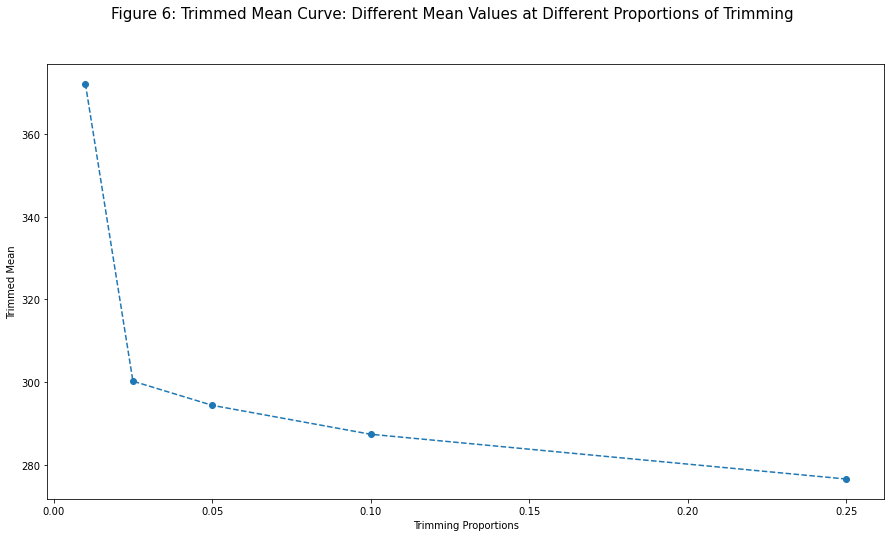

In [37]:
fig, ax8 = plt.subplots()
fig.suptitle('Figure 6: Trimmed Mean Curve: Different Mean Values at Different Proportions of Trimming', fontsize=15)
fig.set_size_inches(15, 8)
line1 = ax8.plot(proportions, trimmed_mean_lst, marker= 'o', linestyle= 'dashed')
ax8.set_xlabel('Trimming Proportions')
ax8.set_ylabel('Trimmed Mean');

Figure 6 shows the mean values when different sizes of the dataset from the leftmost and the rightmost halves are sliced off. Intuitively, the more data is removed from the dataset, the more the mean reduces.

It is possible that since there is a huge dip in mean value when going from 0.01 to 0.05, the outliers comprising store 42 and store 78 were removed. It could also be possible that some of the outlier values, that were not in rightmost 1% or rightmost 5% were removed when 10% of the data from both ends was removed and mean was calculated of the remaining 80% (i.e. proportion = 0.1).

In [38]:
trimmed_dfs = dict()

for i in proportions:
    trimmed_dfs['{} percent'.format(i * 100)] = pd.DataFrame(stats.trimboth(df_sneakers[['shop_id', 'order_amount']], i), columns=['Shop ID', 'Order Amount'])



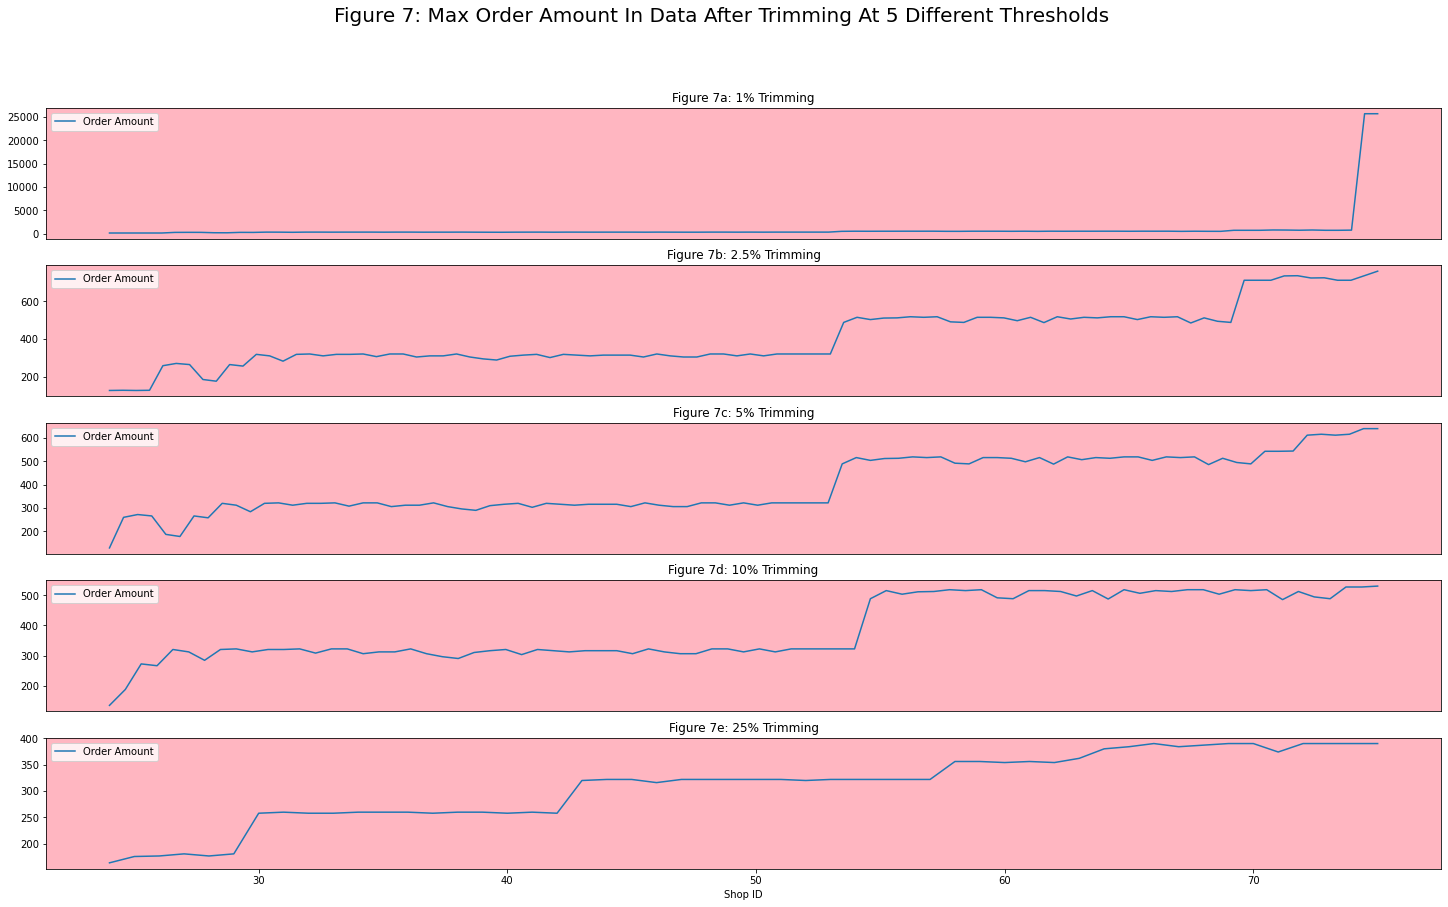

In [39]:
fig, (ax9, ax10, ax11, ax12, ax13) = plt.subplots(5)
fig.suptitle('Figure 7: Max Order Amount In Data After Trimming At 5 Different Thresholds', fontsize=20)
fig.set_size_inches(25, 14)
trimmed_dfs['1.0 percent'].groupby('Shop ID').agg({'Order Amount': "max" }).plot(ax = ax9)
ax9.set_title('Figure 7a: 1% Trimming')
ax9.axes.xaxis.set_visible(False)
ax9.set_facecolor('lightpink')

trimmed_dfs['2.5 percent'].groupby('Shop ID').agg({'Order Amount': "max" }).plot(ax = ax10)
ax10.set_title('Figure 7b: 2.5% Trimming')
ax10.axes.xaxis.set_visible(False)
ax10.set_facecolor('lightpink')

trimmed_dfs['5.0 percent'].groupby('Shop ID').agg({'Order Amount': "max" }).plot(ax = ax11)
ax11.set_title('Figure 7c: 5% Trimming')
ax11.axes.xaxis.set_visible(False)
ax11.set_facecolor('lightpink')

trimmed_dfs['10.0 percent'].groupby('Shop ID').agg({'Order Amount': "max" }).plot(ax = ax12)
ax12.set_title('Figure 7d: 10% Trimming')
ax12.axes.xaxis.set_visible(False)
ax12.set_facecolor('lightpink')

trimmed_dfs['25.0 percent'].groupby('Shop ID').agg({'Order Amount': "max" }).plot(ax = ax13)
ax13.set_title('Figure 7e: 25% Trimming')
ax13.set_facecolor('lightpink')



The various subplots in Figure 7 shows what is the maximum order amount in the dataset after trimming the dataset by x%, where x has taken 5 different values. It can be seen from Figure 7a that the outliers that skewed the Average Order Value are still present after 1% trimming, but are significantly removed after 2.5% of the data has been trimmed from the leftmost and the rightmost side of the data. 

After 5% trimming, it can be ensured that outliers not as extreme but still quite further from the mean have completely been removed.
#### Important Note:
The data is sorted in ascending order before trimming takes place. Furthermore, if there is x% trimming of data, that means (x/2)% is removed from the leftmost side of the data and the same amount is removed from the rightmost side of the data. For instance, if 10% data is trimmed, it implies the mean of values after truncating the lowest and highest 5% of the values.

### Average Order Median

In [40]:
df_sneakers.order_amount.median()

284.0

The median, also known as the value separating the higher half from the lower half of a data sample. In this case, it can be thought of as a middle value of the dataset. 

It can be noticed here that the median is 284. This is close to when 10% of the data is trimmed and the mean is calculated. Although trimmed mean is more robust to outliers than original mean, and there's a wide range of values to choose from, it's better to prefer using the median, as it is more precise to find the center of the data.

In [41]:
#exclude shop 78
df_sneakers
rpv = no_outliers.groupby('user_id').agg({'order_amount': 'sum'}).reset_index(drop=False)

In [42]:
df_sneakers.loc[df_sneakers.user_id == 999]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
207,208,88,999,176,1,debit,2017-03-08 11:30:01
342,343,98,999,266,2,cash,2017-03-23 03:32:01
945,946,10,999,592,4,cash,2017-03-06 20:06:29
1244,1245,23,999,312,2,debit,2017-03-17 11:37:49
2110,2111,10,999,296,2,cash,2017-03-13 04:22:29
2267,2268,19,999,489,3,credit_card,2017-03-26 21:25:42
2332,2333,61,999,632,4,credit_card,2017-03-18 03:07:06
2431,2432,46,999,166,1,cash,2017-03-26 19:38:42
2740,2741,40,999,322,2,cash,2017-03-19 17:56:54
2887,2888,48,999,117,1,credit_card,2017-03-23 09:11:08


Finally, if there was information about visitors on the website who didn't become customers, that could've been used to calculate conversion rate against the shops' revenue. Conversion Rates are an important metric alongside AOV; the former can help understand how many visitors on in a given timeframe chose to became customers. One could ponder about the impact of seasonality as well if conversion rates are at hand. Given more data, there's many more metrics that could be explored. 

## Question 2:
Submitted in the Word Document
